## 3. Getting Started with Neural Networks

### Predicting House Prices: A Regression Example

In the **housing prices** problem, the goal is to predict a value instead of a discrete label. This is an example of a regression problem, and is different from the classification problem we had in the past examples.

In [1]:
from keras.datasets import boston_housing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split

from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers

from tensorflow import keras as tf_keras

Using TensorFlow backend.


In [2]:
##########
# Ingestion
##########
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

The data consists of 404 training examples and 102 test samples, each with 13 numericlal features. They are the median price of homes in a Boston suburb in the mid-1970s.

In [3]:
# For testing
# print([td[:] for td in train_data[0:3]])
# print(train_labels[0:3])

Before we fit the data into the network, we perform feature scaling. 

In [4]:
##########
# Preprocessing
##########
sc = StandardScaler()
x_train = sc.fit_transform(train_data)
x_test = sc.transform(test_data)

num_features = x_train.shape[1]

As the number of samples is small, we use a small network with two hidden layers, each with 64 units. This will help to mitigate overfitting.

This model ends with a single unit and no activation. This is typical for a scalar regression problem (predict only a scalar value). 

In [5]:
def build_model(num_features=13):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(num_features,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

Now, instead of train-test split, we will use k-fold cross validation. In this case, k is 4. Note that we are trying to grid search on no. of epochs to find the best value.

In [6]:
kf = KFold(n_splits=4, random_state=0, shuffle=True)

f = 1
mae_histories = []
num_epochs = 100

##########
# Train & Model Tuning
##########
for ftrain_index, ftest_index in kf.split(x_train):
    print("Processing fold " + str(f))
    
    f_xtrain = x_train[ftrain_index]
    f_xtest = x_train[ftest_index]
    f_ytrain = train_labels[ftrain_index]
    f_ytest = train_labels[ftest_index]
    
    model = build_model()
    history = model.fit(f_xtrain, f_ytrain, 
                        validation_data=(f_xtest, f_ytest), 
                        epochs = num_epochs, batch_size=1, 
                        verbose=0)
    mae_histories.append(history)
    f +=1

Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4


Let's check the MAE scores for each of the folds, followed by the mean of the MAE scores.

In [7]:
# For testing
# for h in mae_histories:
#     print(h.history['val_mae'][-1])

In [8]:
# Performance evaluation using MAE
val_maes = [h.history['val_mae'][-1] for h in mae_histories]
print(val_maes)
print(np.mean(np.array(val_maes)))

[2.525017261505127, 2.4476616382598877, 2.1648025512695312, 2.6725945472717285]
2.4525189995765686


The different runs show different MAE scores. The average is a much more reliable metric.

Let's now try with 500 epochs.

In [9]:
##########
# Train / Model Tuning
##########

f = 1
mae_histories = []
num_epochs = 500

for ftrain_index, ftest_index in kf.split(x_train):
    print("Processing fold " + str(f))
    
    f_xtrain = x_train[ftrain_index]
    f_xtest = x_train[ftest_index]
    f_ytrain = train_labels[ftrain_index]
    f_ytest = train_labels[ftest_index]
    
    model = build_model()
    history = model.fit(f_xtrain, f_ytrain, 
                        validation_data=(f_xtest, f_ytest), 
                        epochs = num_epochs, batch_size=1, 
                        verbose=0)
    mae_histories.append(history)
    f +=1

Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4


In [10]:
# MAE across different folds
val_maes2 = [h.history['val_mae'][-1] for h in mae_histories]
print(val_maes2)
print(np.mean(np.array(val_maes2)))

[2.6322991847991943, 2.8974709510803223, 2.3006911277770996, 3.0305492877960205]
2.715252637863159


Let's now compute the MAE across the different epochs.

In [11]:
val_maes_by_fold = [h.history['val_mae'] for h in mae_histories]
val_maes_by_epoch = np.array(val_maes_by_fold).transpose()
mean_val_maes_by_epoch = np.mean(val_maes_by_epoch, axis=1)

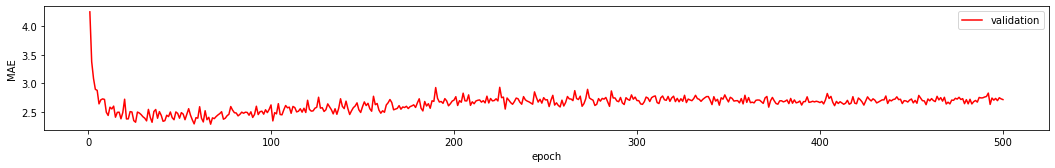

In [12]:
metrics_df = pd.DataFrame({'val_mae' : mean_val_maes_by_epoch})
metrics_df['epoch'] = metrics_df.index+1

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(211)
metrics_df.plot(kind='line', x='epoch', y='val_mae', ax=ax, label='validation', color='red',)
ax.set_ylabel("MAE")
plt.show()

Plotting these values here seem hard. Let's omit the first 10 data points, and Replace each point with an exponential moving average of previous points.

In [13]:
metrics_df2 = metrics_df.iloc[10:].copy()
metrics_df2['val_mae_ewm'] = pd.Series.ewm(metrics_df2['val_mae'], span=5).mean()

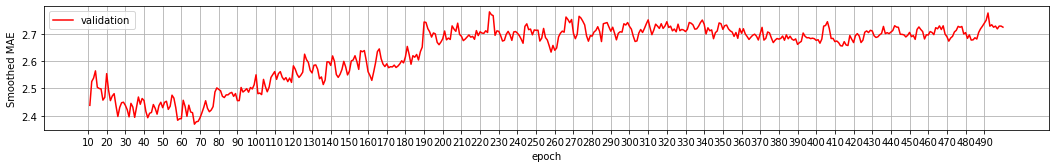

In [14]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(211)
metrics_df2.plot(kind='line', x='epoch', y='val_mae_ewm', ax=ax, label='validation', color='red',)
ax.set_ylabel("Smoothed MAE")
ax.set_xticks(range(10,500,10))
ax.grid()
plt.show()

From here we can see that the validation MAE stops improving after about 60 epochs. So we use this as the tuned parameter.

In [15]:
##########
# Tuned Model 
##########
final_model = build_model()
final_model.fit(f_xtrain, f_ytrain, 
                        validation_data=(f_xtest, f_ytest), 
                        epochs = 60, batch_size=1, 
                        verbose=0)

In [16]:
##########
# Evaluate on Test Set
##########
test_mse_score, test_mae_score = final_model.evaluate(x_test, test_labels)
print(test_mae_score)

102/102 [==============================] - 0s 53us/step
2.7454662322998047


MAE is about $2810

In [17]:
##########
# Predict
##########
final_model.predict(test_data[:5])

array([[998.2407 ],
       [591.47284],
       [805.2824 ],
       [499.1135 ],
       [740.59357]], dtype=float32)

### Tensorflow Implementation

In [18]:
# Train-test split
x_train__train, x_train__val, y_train__train, y_train__val = train_test_split(x_train, train_labels)

# Train
modeli = tf_keras.models.Sequential([
    tf_keras.layers.Dense(64, activation='relu', input_shape=(num_features,)),
    tf_keras.layers.Dense(1),
])
modeli.compile(optimizer='sgd', loss='mean_squared_error', metrics=['mae'])
modeli.fit(x_train, train_labels, 
           validation_data=(x_train__val, y_train__val), 
           epochs = 20, verbose=0)

In [19]:
# Evaluate 
modeli.evaluate(x_test, test_labels)

# Predict
modeli.predict(x_test[:3])

4/4 [==============================] - 0s 1ms/step - loss: 18.3456 - mae: 2.8819


array([[ 8.899626],
       [18.566061],
       [22.922548]], dtype=float32)